# Network Analysis Lab

Complete the following exercises to help solidify your understanding of network analysis.

In [89]:
import networkx as nx
import nxviz
import community
import pandas as pd

## U.S. Mens Basketball Data Set

In the `us_mens_basketball.csv` data set, each row represents an single basketball player's participation in a single event at a single Olympics. 

In [5]:
basketball = pd.read_csv('../data/us_mens_basketball.csv')

In [6]:
basketball.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,351,Julius Shareef Abdur-Rahim,M,23.0,202.0,104.0,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold
1,2636,"Stephen Todd ""Steve"" Alford",M,19.0,185.0,74.0,United States,USA,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Men's Basketball,Gold
2,2863,Walter Ray Allen,M,25.0,192.0,93.0,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold
3,3874,"William Lloyd ""Willie"" Anderson, Jr.",M,21.0,200.0,86.0,United States,USA,1988 Summer,1988,Summer,Seoul,Basketball,Basketball Men's Basketball,Bronze
4,4505,Carmelo Kyan Anthony,M,20.0,203.0,109.0,United States,USA,2004 Summer,2004,Summer,Athina,Basketball,Basketball Men's Basketball,Bronze


## 1. Transform this data set into one that can be turned into a graph where the entities are represented by the Name field and the relationships are represented by whether the players played in the same Olympics together (Games field).

Sort descending by the number of pairwise interactions. Which pair of players have competed in the most Olympics together?

In [7]:
column_ID = 'Name'
column_edge = 'Games'

bb_temp = basketball[[column_ID, column_edge]].dropna(subset=[column_edge]).drop_duplicates() 

In [8]:
bb_temp = bb_temp.merge(bb_temp[[column_ID, column_edge]].rename(columns={column_ID:column_ID+"_2"}),
                        on=column_edge)

In [9]:
df = bb_temp[~(bb_temp[column_ID]==bb_temp[column_ID+"_2"])] \
    .dropna()[[column_ID, column_ID+"_2", column_edge]] # remove self connections and redundancies

In [10]:
df.drop(df.loc[df[column_ID+"_2"]<df[column_ID]].index.tolist(), inplace=True)

In [11]:
df.head()

,Name,Name_2,Games
1,Julius Shareef Abdur-Rahim,Walter Ray Allen,2000 Summer
2,Julius Shareef Abdur-Rahim,"Vincent Lamont ""Vin"" Baker",2000 Summer
3,Julius Shareef Abdur-Rahim,"Vincent Lamar ""Vince"" Carter",2000 Summer
4,Julius Shareef Abdur-Rahim,Kevin Maurice Garnett,2000 Summer
5,Julius Shareef Abdur-Rahim,"Timothy Duane ""Tim"" Hardaway",2000 Summer


## 2. Use the `from_pandas_edgelist` method to turn the data frame into a graph.

In [12]:
G = nx.from_pandas_edgelist(df=df, source=column_ID, target=column_ID+'_2', edge_attr=column_edge)
G.add_nodes_from(nodes_for_adding=df.Name.tolist())

/home/fred/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


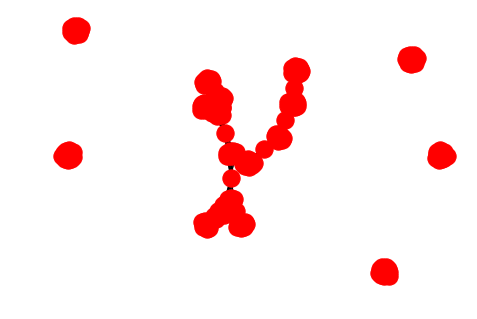

In [13]:
nx.draw(G)

## 3. Compute and print the following graph statistics for the graph:

- Number of nodes
- Number of edges
- Average degree
- Density

In [17]:
len(G.nodes)

196

In [18]:
len(G.edges)

1232

In [19]:
import numpy as np

np.mean([list(G.degree)[i][1] for i in range(len(G.degree))])

12.571428571428571

In [24]:
nx.density(G)

0.06446886446886448

## 4. Compute betweenness centrality for the graph and print the top 5 nodes with the highest centrality.

In [35]:
pd.DataFrame.from_dict(nx.betweenness_centrality(G, weight = 'edge').items()).sort_values(by=1, ascending=False).head()

,0,1
11,Gary Dwayne Payton,0.091938
8,Jason Frederick Kidd,0.091356
36,Carmelo Kyan Anthony,0.047423
33,David Maurice Robinson,0.032662
175,"William Marion ""Bill"" Hougland",0.030241


## 5. Compute Eigenvector centrality for the graph and print the top 5 nodes with the highest centrality.

In [38]:
pd.DataFrame.from_dict(nx.eigenvector_centrality_numpy(G).items()).sort_values(by=1, ascending=False).head()

,0,1
36,Carmelo Kyan Anthony,0.341850
38,LeBron Raymone James,0.288454
54,Deron Michael Williams,0.224317
49,Kobe Bean Bryant,0.224317
51,"Christopher Emmanuel ""Chris"" Paul",0.224317


## 6. Compute degree centrality for the graph and print the top 5 nodes with the highest centrality.

In [39]:
pd.DataFrame.from_dict(nx.degree_centrality(G).items()).sort_values(by=1, ascending=False).head()

,0,1
36,Carmelo Kyan Anthony,0.184615
33,David Maurice Robinson,0.143590
38,LeBron Raymone James,0.133333
129,"Robert Albert ""Bob"" Kurland",0.133333
175,"William Marion ""Bill"" Hougland",0.123077


## 7. Generate a network visualization for the entire graph using a Kamada-Kawai force-directed layout.

/home/fred/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


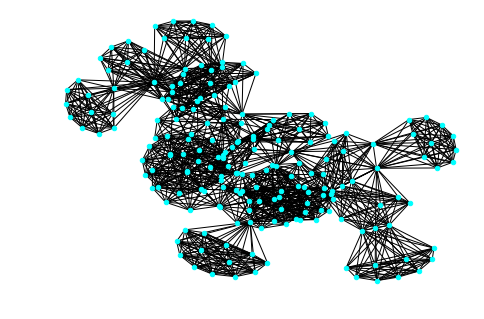

In [45]:
nx.draw_kamada_kawai(G, node_size=20, node_color='cyan')

## 8. Create and visualize an ego graph for the player with the highest betweenness centrality.

In [70]:
player = pd.DataFrame.from_dict(nx.betweenness_centrality(G).items()).sort_values(by=1, ascending= False).head()[0].values[0]

In [78]:
ego = nx.ego_graph(G, player, radius=1)

/home/fred/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


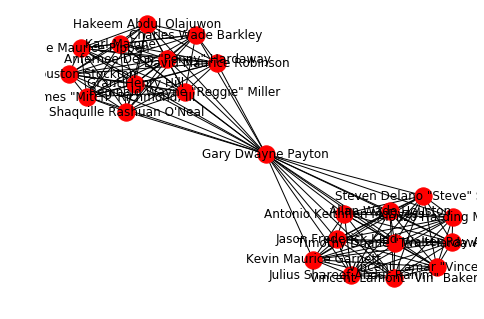

In [79]:
nx.draw(ego, with_labels = True)

## 9. Identify the communities within the entire graph and produce another visualization of it with the nodes color-coded by the community they belong to.

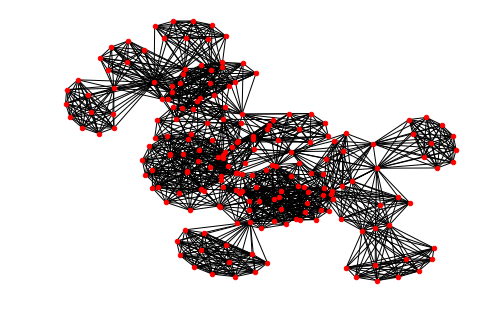

In [102]:
from community import community_louvain as c

values = list(c.best_partition(G.to_undirected()).values())
nx.draw_kamada_kawai(G, node_size = 20, node_colors = values)

## Bonus: Hierarchical Graphs

Thus far, we have analyzed graphs where the nodes represented individual players and the edges represented Olympic games that they have competed in together. We can analyze the data at a higher level if we wanted to, strippping out the players as entities and analyzing the data at the Games level. To do this, we would need to reconstruct the graph so that the *Games* field represents the entities and then use the player names as the edge criteria so that there would be an edge between two Olympic games if an player played in both of them. You already have the tools in your toolbox to be able to do this, so give it a try. 

### Create a graph with Games as the entities and then print out the graph statistics.

In [118]:
column_edge = 'Name'
column_ID = 'Games'

G = nx.from_pandas_edgelist(basketball, source='Games', target = 'Name', edge_attr=True)
print(nx.info(G)[18:], '\nDensity: ', nx.density(G))



Number of nodes: 214
Number of edges: 222
Average degree:   2.0748 
Density:  0.009740687113334211


### Generate a network visualization of this graph using the layout of your choice.

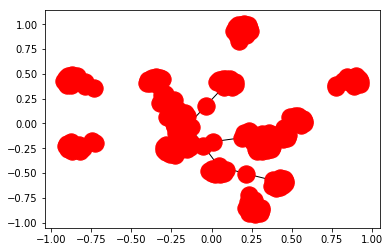

In [121]:
nx.draw_networkx(G, with_labels= False)